In [1]:
#作者：ZY，意见或讨论请联系986561785@qq.com
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
#difining a sign function.
def sign(x):
    x[x>=0] = 1
    x[x<0] =-1
    return x

In [3]:

def overlap(ol):
    '''
    input: a overlap matrix, ol.shape = n_h*n_h
    output:  the largest overlap, 
    '''
    a = ol.shape[0]
    ol_temp = np.abs(ol)
    ol_max = np.zeros([1,a])
    for i in range(a):
        row,colunm = np.where(ol_temp == ol_temp.max())#finding the index of largest absolute overlap
        ol_max[0][row] = ol[row[0],colunm[0]]
        ol_temp[row[0],:] = 0 
        ol_temp[:, colunm[0]] = 0
    return ol_max

In [4]:
def gibbs_sampling(beta,xi, alpha = 1): 
    '''
    Gibbs sampling function to generate data
    beta: inverse temperature
    xi: the weights, shape:n_v*n_h，
    alpha: data density
    '''
    N = xi.shape[0]
    v = np.random.choice([-1,1],[1,N])
    sigma = []
    for i in range( int(alpha*N*500)+10000 ):
        
        h = sign( np.exp( beta/np.sqrt(N) * np.dot(v,xi) ) /2 /np.cosh(beta/np.sqrt(N)*np.dot(v,xi)) \
            -  np.random.uniform(0,1,[1,xi.shape[1]]))
        
        v = sign( np.exp(beta/np.sqrt(N) * (h.dot(xi.T))) /np.cosh(beta/np.sqrt(N)*(h.dot(xi.T)) )/2 \
            - np.random.uniform(0,1,[1,N]) )
        
        if ((i+1)%500 == 0) & (i>10000):
            sigma.append(v)
    return np.squeeze(np.asarray(sigma))

In [5]:
class RBM_binary():
    
    def __init__(self, n_v, n_h, beta, lr=0.1, gamma_1 = 0.9, gamma_2 = 0.99):
        '''
        A class of binary RBM,
        n_v: number of visible nodes
        n_h: number of hidden nodes
        beta: inverse temperature
        lr: learning rate
        gamma_1, gamma_2: parameters of Adam training.
        
        '''
        
        self.n_v = n_v 
        self.n_h = n_h 
        self.beta = beta 
        self.xi = np.random.choice([-1,1],[n_v,n_h]) 
        self.ld = 2*np.random.rand(n_v,n_h)-1 
        self.m = np.zeros([n_v,n_h])
        self.lr = lr
        self.momentum = 0
        self.gamma_1 = gamma_1
        self.gamma_2 = gamma_2
        self.adam_1 = 0
        self.adam_2 = 0
        self.KL = -1/2*( (1+self.ld)*np.log( (1+self.m)/2) + (1-self.ld)*np.log( (1-self.m)/2) \
                       - (1+self.ld)*np.log((1+self.ld)/2) - (1-self.ld)*np.log((1-self.ld)/2)).sum()
        self.LB = 0
        
    def forward(self,sigma): 
        '''
        The forward Gibbs sampling process
        '''
        return sign( np.exp( beta/np.sqrt(self.n_v) * np.dot(sigma,self.xi) ) /2 /np.cosh(beta/np.sqrt(self.n_v)*np.dot(sigma,self.xi)) \
            -  np.random.uniform(0,1,[sigma.shape[0],self.xi.shape[1]]))
    
    def backward(self,h):
        '''
        The backward Gibbs sampling process
        '''
        return sign( np.exp(beta/np.sqrt(self.n_v) * (h.dot(self.xi.T))) /np.cosh(beta/np.sqrt(self.n_v)*(h.dot(self.xi.T)) )/2 \
            - np.random.uniform(0,1,[h.shape[0],self.n_v]) )
    
        
    def grad(self, sigma):#sigma.shape: [M,n_v],输入数据进行训练
        '''
        Calculating gradients using the variational method.
        sigma: data, shape:M*n_v, M is the quantity of data. 
        '''
        n_rn = 1000#number of random number in Monte Carlo
        #grad of KL
        delta1 = 1/2*( np.log( (1+self.m)/(1+ self.ld)) - np.log((1-self.m)/(1- self.ld)) )
        
        #grad of first term of expected likelihood
        G = 1/np.sqrt(self.n_v)*(sigma.dot(self.ld))  
        Xi = np.sqrt( 1/self.n_v* (1-self.ld**2).sum(0).reshape(1,self.n_h) )  
        rn = np.random.randn(n_rn,1,self.n_h) 
        delta2 = self.beta/np.sqrt(self.n_v)*( np.matmul(sigma.T, np.tanh(self.beta*G + self.beta*Xi*rn)  ).mean(0))
        
        delta3 = -1*self.beta**2*self.ld/self.n_v * \
                 (1 - np.power( np.tanh(self.beta*G + self.beta*Xi*rn ), 2)).sum(0).sum(0).reshape(1,self.n_h) /n_rn
        
        #grad of second term of expected likelihood
        delta4 = 0
        i = 0
        F = 0
        rn = np.random.randn(n_rn,1,self.n_h)
        b = Xi * rn
        m = np.random.rand(n_rn,self.n_v,self.n_h)
        chi = 1/np.sqrt(self.n_v)*( (self.ld*m).sum(1).reshape(n_rn,1,self.n_h) - self.ld*m).transpose((0,2,1))
        u = np.arctanh( np.tanh(self.beta*chi+self.beta*b.transpose((0,2,1))) *np.tanh(self.beta*self.ld.T/np.sqrt(self.n_v)))

        for j in range(500): 
            if j == 0:
                diverged = np.ones([n_rn])
            else:
                diverged = np.abs(m-temp).sum(2).sum(1)
            temp = m*1
             
            
            chi[diverged> 1e-5] = 1/np.sqrt(self.n_v)*( (self.ld*m[diverged> 1e-5]).sum(1).reshape(-1,1,self.n_h) - self.ld*m[diverged> 1e-5]).transpose((0,2,1))
            
            u[diverged> 1e-5] = np.arctanh( np.tanh(self.beta*chi[diverged> 1e-5]+self.beta*b.transpose((0,2,1))[diverged> 1e-5]) *np.tanh(self.beta*self.ld.T/np.sqrt(self.n_v)))
            m[diverged> 1e-5] = np.tanh( (u.sum(1).reshape(-1,1,self.n_v)[diverged> 1e-5]-u[diverged> 1e-5]).transpose((0,2,1)) )
            if np.abs(m-temp).sum()<1e-5:
                #print('converged',j)
                converged = True
                break;
            if j == 499:
                print('fail',end=';')
        
        Lambda = np.sqrt( ((self.ld**2 * (1-m**2)).sum(1)[:,np.newaxis] - self.ld**2 * (1-m**2) ).transpose((0,2,1))/self.n_v )
        Fi = (self.beta**2*Lambda**2/2 + np.log(np.cosh( self.beta*chi + self.beta*b.transpose((0,2,1)) +self.beta*self.ld.T/np.sqrt(self.n_v)  )) ).sum(1)[:,np.newaxis]\
            + np.log(1+np.exp(-2*u.sum(1)))[:,np.newaxis]
        x = (np.log(np.cosh( self.beta*chi + self.beta*b.transpose((0,2,1)) +self.beta*self.ld.T/np.sqrt(self.n_v)  )) )
        
        Fi = Fi.sum(2)
        chi = 1/np.sqrt(self.n_v)*(self.ld*m).sum(1)[:,np.newaxis]
        Lambda = np.sqrt( (self.ld**2 * (1-m**2)).sum(1) /self.n_v )[:,np.newaxis]
        Fa = (self.beta**2*Lambda**2/2 + np.log( np.cosh( self.beta*( chi + b ) ) ))
        
        Fa = Fa.sum(2)
        F = (Fi - Fa*(self.n_v - 1)).mean()
        
        m = np.tanh(u.sum(1))[:,np.newaxis]
        chi = 1/np.sqrt(self.n_v)*(self.ld*m.reshape(n_rn,self.n_v,1)).sum(1)[:,np.newaxis]
        Lambda = np.sqrt( (self.ld**2 * (1-m**2).reshape(n_rn,self.n_v,1)).sum(1) /self.n_v )[:,np.newaxis]
        
        n_rn1 = 1000 
        int_rn = np.random.standard_normal([n_rn1,1,1,self.n_h])
        
        m_hat = np.tanh(self.beta * (chi + b +int_rn*Lambda)).mean(0)
        A = 1 - ( np.tanh(self.beta * (chi + b +int_rn*Lambda)) **2).mean(0)
        c = np.matmul(m.transpose(0,2,1),m_hat) + self.beta*self.ld/np.sqrt(self.n_v) \
            * np.matmul((1-m**2).transpose((0,2,1)),A)
        
        delta4 = (c - self.ld/np.sqrt(self.n_v)*(rn*m_hat/Xi)).mean(0)
        delta4 = -1*sigma.shape[0]*self.beta*delta4/np.sqrt(self.n_v)
        
        #calculation of KL and LB
        self.KL = -1/2*( (1+self.ld)*np.log( (1+self.m)/2) + (1-self.ld)*np.log( (1-self.m)/2) \
                       - (1+self.ld)*np.log((1+self.ld)/2) - (1-self.ld)*np.log((1-self.ld)/2)).sum()
        rn = np.random.standard_normal([n_rn,1,self.n_h])
        ExpLL1 = np.log( np.cosh(self.beta*G + self.beta*Xi*rn) ).sum()/n_rn
        ExpLL2 = F
        self.LB = -1*self.KL + ExpLL1 - sigma.shape[0]*ExpLL2
        
        return delta1+delta2+delta3+delta4
    
    def adam_update(self,sigma):
        grad = self.grad(sigma)
        
        self.adam_1 = self.gamma_1*self.adam_1 + (1-self.gamma_1)*(grad)
        self.adam_2 = self.gamma_2*self.adam_2 + (1-self.gamma_2)*(grad)**2
        m_hat = self.adam_1/(1-self.gamma_1)
        s_hat = self.adam_2/(1-self.gamma_2)
        self.ld += self.lr*m_hat/(np.sqrt(s_hat)+1e-8)
        
        #limiting the lambda
        self.ld[self.ld>=1] = 0.99999 
        self.ld[self.ld<=-1] = -0.99999  
        self.xi = sign(self.ld*1)
        

In [6]:
def experiment_of_two_hidden():
    np.random.seed(0)
    n_v = 100
    n_h = 2
    beta = 1
    q = 0.3
    
    xi = np.random.choice([-1,1],[n_v,n_h])
    sigma = gibbs_sampling(beta, xi, alpha = 5)
    rbm = RBM_binary(n_v,n_h, beta, lr = 0.4)
    xi1 = np.random.choice([-1,1],[n_v,1])
    xi2 = sign( (q+1)/2 - np.random.rand(n_v,1))*xi1
    xi_p = np.column_stack((xi1,xi2))
    sigma_p = gibbs_sampling(beta, xi_p, alpha = 5)
    rbm_p = RBM_binary(n_v,n_h, beta, lr = 0.4)
    
    ol = []
    kl = []
    LB = []
    t1 = time.time()
    for i in range(200):
        rbm.adam_update(sigma)
        rbm_p.adam_update(sigma_p)
        ol.append([overlap(np.abs((rbm.ld*1).T.dot(xi))/100),overlap(np.abs((rbm_p.ld*1).T.dot(xi_p))/100)])
        kl.append([rbm.KL,rbm_p.KL])
        LB.append([rbm.LB,rbm_p.LB])
        if i % 20 == 0:
            rbm.lr *= 1
        
    ol = np.asarray(ol).squeeze()
    A = plt.figure(figsize=(6,12))
    marks = ['r', 'b', 'g','b']
    label = [r'q=0, $Q^{1}$',r'q=0, $Q^{2}$',r'q=0.3, $Q^{1}$',r'q=0.3, $Q^{2}$']
    plt.subplot(3,1,1)
    for i in range(2):
        plt.plot([i for i in range(ol.shape[0])], ol[:,i,0],marks[i], label = label[i])
        plt.plot([i for i in range(ol.shape[0])], ol[:,i,1],marks[i+2], label = label[i+2])
    plt.legend()
    plt.xlabel('learning steps')
    plt.ylabel('overlap')

    kl = np.asarray(kl)
    plt.subplot(3,1,2)
    plt.plot([i for i in range(kl.shape[0])],kl[:,0],'b',label = 'q=0')
    plt.plot([i for i in range(kl.shape[0])],kl[:,1],'r',label = 'q=0.3')
    plt.xlabel('learning steps')
    plt.ylabel('KL')
    plt.legend()
    LB = np.asarray(LB)
    plt.subplot(3,1,3)
    plt.plot([i for i in range(LB.shape[0])], LB[:,0],'b',label = 'q=0')
    plt.plot([i for i in range(LB.shape[0])], LB[:,1],'r',label = 'q=0.3')
    plt.legend()
    plt.xlabel('learning steps')
    plt.ylabel('LB')
    plt.show()

In [7]:
def experiment_of_three_hidden():
    np.random.seed(0)
    n_v = 100
    n_h = 3
    beta = 1
    
    xi = np.random.choice([-1,1],[n_v,n_h])
    sigma = gibbs_sampling(beta, xi, alpha = 5)
    rbm = RBM_binary(n_v,n_h, beta, lr = 0.4)
    ol = []
    kl = []
    LB = []
    t1 = time.time()
    for i in range(200):
        rbm.adam_update(sigma)
        t2 = time.time()
        
        t1=t2*1
        ol.append(overlap(np.abs((rbm.ld*1).T.dot(xi))/100))
        kl.append(rbm.KL)
        LB.append(rbm.LB)
        if i % 20 == 0:
            rbm.lr *= 1
        
    ol = np.asarray(ol).squeeze()
    A = plt.figure(figsize=(6,12))
    marks = ['r', 'b', 'g']
    label = [r'$Q^{1}$',r'$Q^{2}$',r'$Q^{3}$']
    plt.subplot(3,1,1)
    for i in range(3):
        plt.plot([i for i in range(ol.shape[0])], ol[:,i],marks[i], label = label[i])
    plt.legend()
    plt.xlabel('learning steps')
    plt.ylabel('overlap')

    kl = np.asarray(kl)
    plt.subplot(3,1,2)
    plt.plot([i for i in range(kl.shape[0])],kl,'b',label = 'KL')
    plt.xlabel('learning steps')
    plt.ylabel('KL')
    plt.legend()
    LB = np.asarray(LB)
    plt.subplot(3,1,3)
    plt.plot([i for i in range(LB.shape[0])], LB,'b',label = 'LB')
    plt.legend()
    plt.xlabel('learning steps')
    plt.ylabel('LB')
    plt.show()

In [8]:
def experiment_of_different_alpha():
    np.random.seed(0)
    n_v = 100
    n_h = 3
    beta = 1
    q = 0.3
    ol_10 = []
    kl_10 = []
    LB_10 = []
    for i in range(10):
        ol = []
        kl = []
        LB = []
        for j in range(5):
            alpha = j+1
            xi_3 = np.random.choice([-1,1],[n_v,n_h])
            sigma_3 = gibbs_sampling(beta, xi_3, alpha = alpha)
            rbm_3 = RBM_binary(n_v,n_h, beta, lr = 0.4)
            n_h = 2
            xi1 = np.random.choice([-1,1],[n_v,1])
            xi2 = sign( (q+1)/2 - np.random.rand(n_v,1))*xi1
            xi = np.column_stack((xi1,xi2))
            sigma = gibbs_sampling(beta, xi, alpha = alpha)
            xi_p = np.random.choice([-1,1],[n_v,n_h])
            sigma_p = gibbs_sampling(beta, xi_p, alpha = alpha)
            rbm = RBM_binary(n_v,n_h, beta, lr = 0.1)
            rbm_p = RBM_binary(n_v,n_h, beta, lr = 0.1)
            for k in range(100):
                rbm_3.adam_update(sigma_3)
                rbm.adam_update(sigma)
                rbm_p.adam_update(sigma_p)
            t2 = time.time()
            
            t1=t2*1
            ol.append([overlap(np.abs(sign(rbm_3.ld*1).T.dot(xi_3))/100).mean(),
                        overlap(np.abs(sign(rbm.ld*1).T.dot(xi))/100).mean(), 
                       overlap(np.abs(sign(rbm_p.ld*1).T.dot(xi_p))/100).mean(),
                      ])
            kl.append([rbm_3.KL*1,rbm.KL*1,rbm_p.KL*1])
            LB.append([rbm_3.LB*1,rbm.LB*1,rbm_p.LB*1])
            
        ol_10.append(ol)
    ol_10 = np.asarray(ol_10)
    f = open('alpha_5.19', 'wb')
    pickle.dump(ol_10, f)
    f.close()
    label = ['q=0, P=3', 'q=0, P=2', 'q=0.3, P=2']
    for i in range(3):
        plt.errorbar([i+1 for i in range(ol_10.shape[1])], ol_10[:,:,i].mean(0), ol_10[:,:,i].std(0), label = label[i])
    plt.xlabel(r'$\alpha$')
    plt.ylabel('mean overlap with ground true')
    plt.show()

In [9]:
def experiment_of_MNIST():
    np.random.seed(0)
    mnist_train =  torchvision.datasets.MNIST('./', train=True, 
                                               transform=torchvision.transforms.ToTensor(), download=True)
    data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=2000)
    for data, label in data_loader:
        sigma = (data.reshape(-1,784).numpy())
        break
    n_v = 784
    n_h = 4
    beta = 1
    rbm = RBM_binary(n_v,n_h, beta, lr = 0.4)
    kl= []
    LB = []
    t1 = time.time()
    for i in range(200):
        rbm.adam_update(sigma)
        t2 = time.time()
        
        t1 = t2*1
        kl.append(rbm.KL*1)
        LB.append(rbm.LB*1)
    plt.subplot(1,2,1)
    plt.plot([i for i in range(len(kl))],kl,label = 'KL')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot([i for i in range(len(LB))],LB, label = 'LB')
    plt.legend()
    plt.show()

experiment of two hidden node


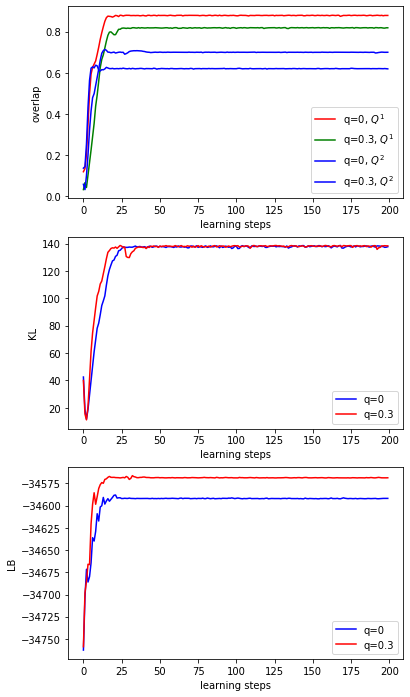

In [10]:
print('experiment of two hidden node')
experiment_of_two_hidden()

experiment of three hidden node


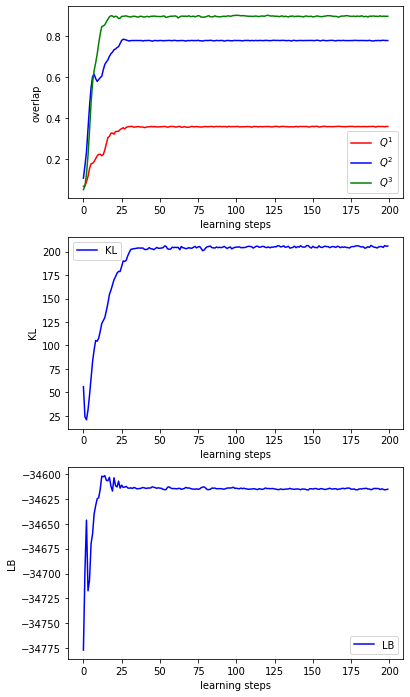

In [11]:
print('experiment of three hidden node')
experiment_of_three_hidden()

experiment of different alpha


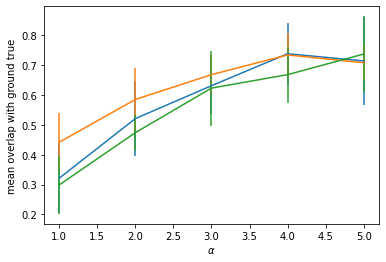

In [12]:
print('experiment of different alpha')
experiment_of_different_alpha()

experiment of MNIST
fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;fail;

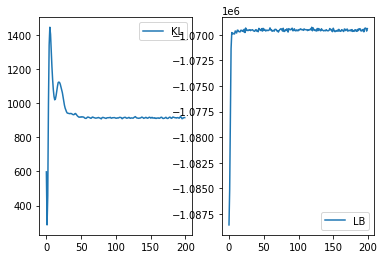

In [13]:
print('experiment of MNIST')
experiment_of_MNIST()